# 数据分析与作图

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re

# 针对ProThermDB数据集[全变异]进行数据分析

In [9]:
protherm = pd.read_csv("BasicData/InitializationDataset/ProThermDB-AllMutations.tsv", sep="\t")
protherm.insert(protherm.columns.get_loc("ΔTm") + 1, "deltaTm", 0.0)
protherm

,NO,Protein,UniProt_ID,Mutation,pH,Tm,ΔTm,deltaTm,SOURCE,PDB_wild,...,m_(kcal/mol/M),Cm_(M),∆G_H2O_(kcal/mol),∆∆G_H2O_(kcal/mol),STATE,REVERSIBILITY,PubMed_ID,KEY_WORDS,REFERENCE,AUTHOR
0,27,NAD+ -dependent formate dehydrogenases (FDHs),A0A1U8PF82,wild-type,7.0,72,-,0.0,Gossypium hirsutum,-,...,-,-,-,-,-,No,33754169,Thermal stability; Oxidative stability; Cumula...,Appl Microbiol Biotechnol. 105(7):2787-2798 (2...,"Kurt S, Ordu E"
1,28,NAD+ -dependent formate dehydrogenases (FDHs),A0A1U8PF82,M225L (Based on Paper),7.0,67,-,0.0,Gossypium hirsutum,-,...,-,-,-,-,-,No,33754169,Thermal stability; Oxidative stability; Cumula...,Appl Microbiol Biotechnol. 105(7):2787-2798 (2...,"Kurt S, Ordu E"
2,29,NAD+ -dependent formate dehydrogenases (FDHs),A0A1U8PF82,M234L (Based on Paper),7.0,66,-,0.0,Gossypium hirsutum,-,...,-,-,-,-,-,No,33754169,Thermal stability; Oxidative stability; Cumula...,Appl Microbiol Biotechnol. 105(7):2787-2798 (2...,"Kurt S, Ordu E"
3,30,NAD+ -dependent formate dehydrogenases (FDHs),A0A1U8PF82,M243L (Based on Paper),7.0,77,-,0.0,Gossypium hirsutum,-,...,-,-,-,-,-,No,33754169,Thermal stability; Oxidative stability; Cumula...,Appl Microbiol Biotechnol. 105(7):2787-2798 (2...,"Kurt S, Ordu E"
4,31,Major prion protein,P04156,wild-type,7.0,71.3,-,0.0,Homo sapiens,1E1G,...,-,-,-,-,-,No,-,amyloid; neurodegenerative diseases; prion pro...,Proc Natl Acad Sci U S A. 118(12):e2019631118 ...,"Sanz-Hernández M, Barritt JD, Sobek J, Hornema..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20005,32270,gkGBP3.14,-,-,7.4,76.7,-,0.0,synthetic,-,...,-,-,-,-,-,-,-,Thermostable; glucose biosensor,"Biochemistry, 61(4), 276–293 (2022) PMID: 3508...","Allert, M. J., & Hellinga, H. W."
20006,32271,gkGBP3.18,-,-,7.4,77.3,-,0.0,synthetic,-,...,-,-,-,-,-,-,-,Thermostable; glucose biosensor,"Biochemistry, 61(4), 276–293 (2022) PMID: 3508...","Allert, M. J., & Hellinga, H. W."
20007,32272,gkGBP3.19,-,-,7.4,76.8,-,0.0,synthetic,-,...,-,-,-,-,-,-,-,Thermostable; glucose biosensor,"Biochemistry, 61(4), 276–293 (2022) PMID: 3508...","Allert, M. J., & Hellinga, H. W."
20008,32273,gkGBP3.20,-,-,7.4,76.5,-,0.0,synthetic,-,...,-,-,-,-,-,-,-,Thermostable; glucose biosensor,"Biochemistry, 61(4), 276–293 (2022) PMID: 3508...","Allert, M. J., & Hellinga, H. W."


In [10]:
single = []                 # 单点变异
double = []                 # 双点变异
multiple = []               # 多点变异
wild = []                   # 野生变异
illegal_mutations = []      # 非法变异
illegal_delatatms = []      # 非法标签
illegal_uniprotid = []      # 非法ID
mutation_lengths = {}       # 变异强度
for rowIndex, row in protherm.iterrows():
    mutation = row["Mutation"]
    deltaTm = row["ΔTm"]

    flag = True
    # 野生蛋白
    if "wild-type" in mutation:
        wild.append(rowIndex)
        flag = False
    # UniProtID缺失
    if pd.isna(row["UniProt_ID"]) or row["UniProt_ID"] == "-":
        illegal_uniprotid.append(rowIndex)
        flag = False
        
    # 非法变异
    if pd.isna(mutation):
        illegal_mutations.append(rowIndex)
        flag = False
    # 非法标签
    if deltaTm == "-":
        illegal_delatatms.append(rowIndex)
        flag = False
    elif "(" in deltaTm:
        protherm.loc[rowIndex, "deltaTm"] = eval(deltaTm[:deltaTm.index("(")])
    elif isinstance(eval(deltaTm), float):
        protherm.loc[rowIndex, "deltaTm"] = eval(deltaTm)
        
    # 处理变异数据
    if "(" in mutation:
        protherm.loc[rowIndex, "Mutation"] = mutation[:mutation.index("(")]
    # 当前数据是否合法
    if not flag:
        continue
        
    # 合法情况:抽取变异强度
    mutation_length = len(re.findall("([A-Z]{1}[0-9]+[A-Z]{1})", mutation))
    mutation_lengths[mutation_length] = mutation_lengths.setdefault(mutation_length, 0) + 1
    if mutation_length == 1:
        single.append(rowIndex)
    elif mutation_length == 2:
        double.append(rowIndex)
    elif mutation_length > 2:
        multiple.append(rowIndex)
    else:
        illegal_mutations.append(rowIndex)

### 提取野生型和非法数据

In [11]:
wild_diagram = protherm.loc[wild, :]
illegal_mutations_diagram = protherm.loc[illegal_mutations, :]
illegal_delatatms_diagram = protherm.loc[illegal_delatatms, :]
illegal_uniprotid_diagram = protherm.loc[illegal_uniprotid, :]

### 突变强度统计

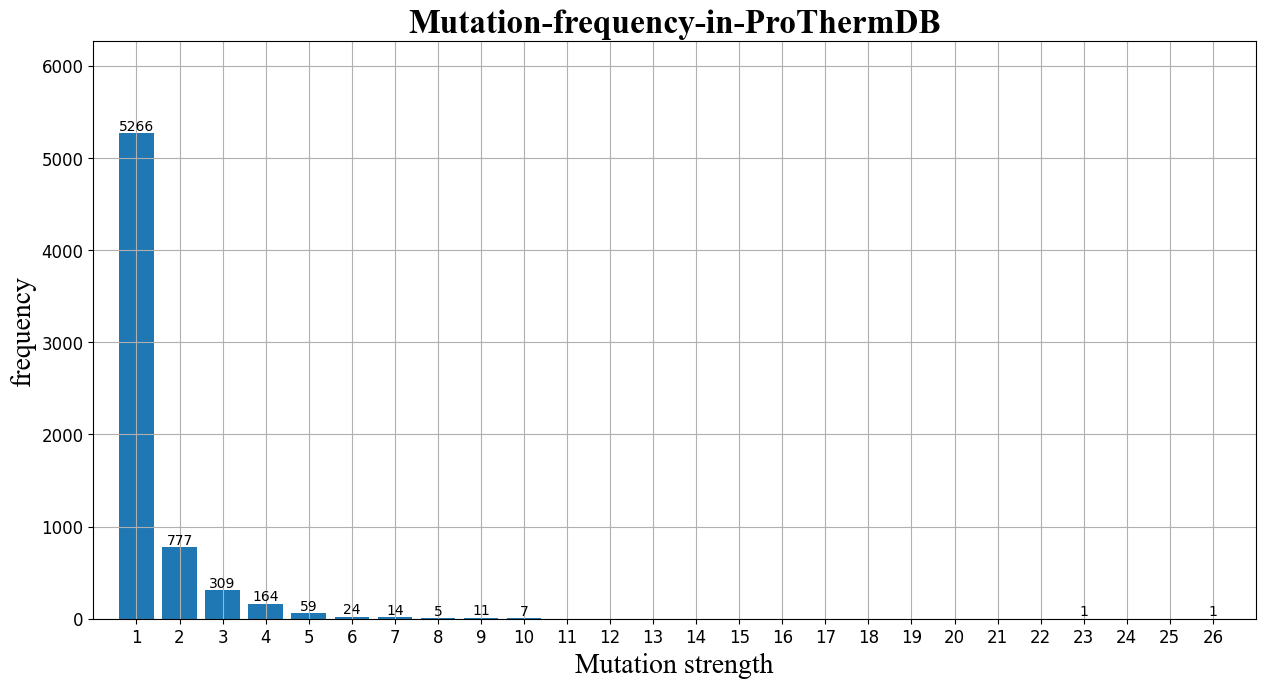

In [12]:
# 提取字典的键和值
x = list(mutation_lengths.keys())
y = list(mutation_lengths.values())


# 设置画布大小
plt.figure(figsize=(15, 7.5), dpi=100)
# 绘制柱状图
plt.bar(x, y)

# 添加数据标签
for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

# 添加标题和标签
plt.title("Mutation-frequency-in-ProThermDB",
          loc="center",
          fontdict={"family" : "Times New Roman",
                    "size" : 24,
                    "weight" : "bold"})
plt.xlabel("Mutation strength", fontdict={"family" : "Times New Roman", "size" : 20, "weight" : "normal"})
plt.ylabel("frequency", fontdict={"family" : "Times New Roman", "size" : 20, "weight" : "normal"})

# 设置坐标轴范围
plt.xlim(min(x)-1, max(x)+1)
plt.ylim(0, max(y)+1000)  # 根据数据范围调整纵坐标轴的长度

# 设置刻度
plt.xticks(range(min(x), max(x)+1), size=12)
plt.yticks(size=12)

# 设置网格线
plt.grid()

# 保存图片
plt.savefig("SavedPicture/Mutation-frequency-in-ProThermDB.png", dpi=100)

# 显示图形
plt.show()

### 单点、双点以及多点突变的数据

In [13]:
single = protherm.loc[single, :]            # 提取单突变数据
double = protherm.loc[double, :]            # 提取单突变数据
multiple = protherm.loc[multiple, :]        # 提取多突变数据

### 清理非法数据

In [7]:
protherm.drop(index=list(set(wild + illegal_mutations + illegal_delatatms + illegal_uniprotid)), inplace=True)  
protherm.reset_index(drop=True, inplace=True) 

AttributeError: 'NoneType' object has no attribute 'reset_index'

### 检测是否存在多测量值数据

In [16]:
def check4mult(df: pd.DataFrame) -> (int, list):
    def pattern(s: pd.Series) -> str:
        path = []
        for subS in s:
            if not isinstance(subS, str):
                path.append(str(subS))
            else:
                path.append(subS)
        return "@".join(path)
    
    select_colmns = ["UniProt_ID", "Mutation"]
    indexs = []
    cnt = 0
    left, right = 0, 1  # 左、右指针
    while right < df.shape[0]:
        # 如果遇到了多测量值
        if pattern(df.loc[left, select_colmns]) == pattern(df.loc[right, select_colmns]):
            while right < df.shape[0] and pattern(df.loc[left, select_colmns]) == pattern(df.loc[right, select_colmns]):
                indexs.append(right)
                right += 1
            cnt += 1
            # 左指针指向下一个可能的重复位点
            left = right
            # 右指针指向下一个可能和左指针相同的位点
            right += 1
        # 没遇到就两个指针往前走
        else:
            left += 1
            right += 1

    return cnt, indexs


cnt, deleteIndex = check4mult(protherm)
multiple_deltaTm = protherm.iloc[deleteIndex, :]
cnt

180

### 对多测量值进行处理

In [17]:
protherm_deleted = protherm[["UniProt_ID", "Mutation", "deltaTm"]].groupby(["UniProt_ID", "Mutation"]).mean().reset_index()
protherm_deleted

,UniProt_ID,Mutation,deltaTm
0,A0A060GYS1,H22R,9.90
1,A0A060GYS1,P224R,2.30
2,A0A410ZNC6,A341S,3.60
3,A0A410ZNC6,F184L,0.00
4,A0A410ZNC6,F184L P250L A341S,5.60
...,...,...,...
4292,R9S082,V67A V115A V14A G24A,2.70
4293,R9S082,V67A V14A,1.60
4294,W0TJ64,D250C E296C,82.41
4295,W0TJ64,S176A,78.74


### 针对∆Tm进行作图

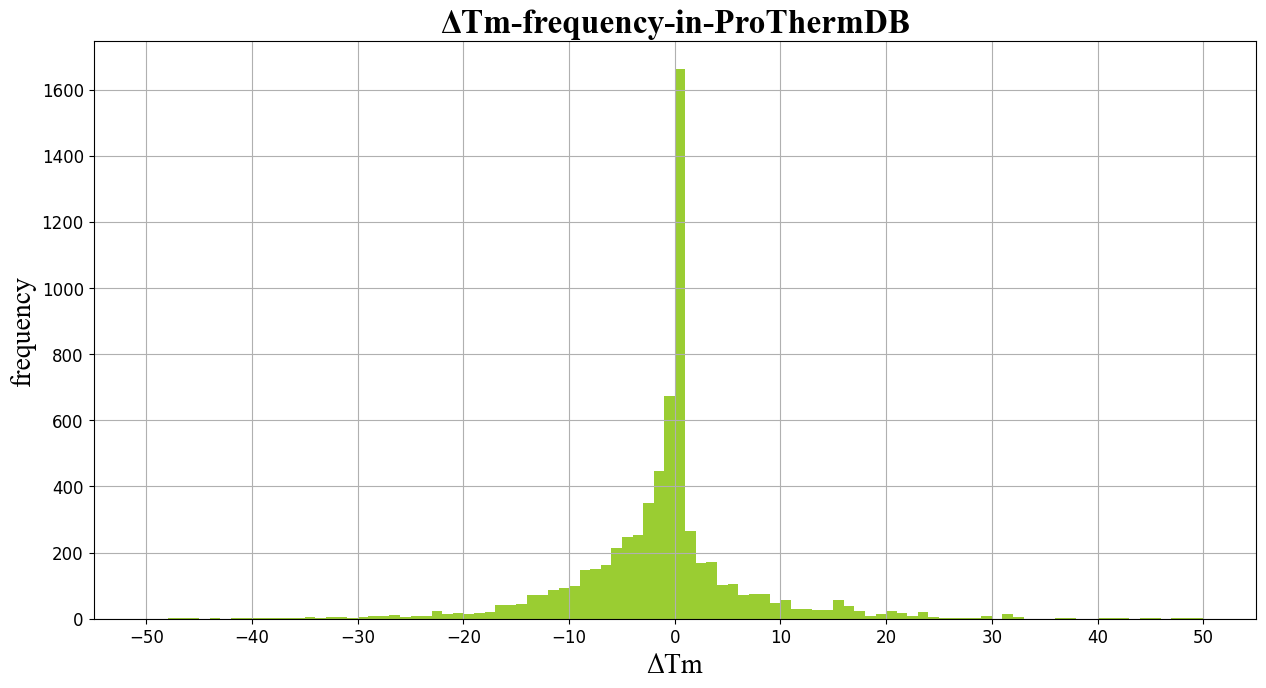

In [18]:
plt.figure(figsize=(15, 7.5), dpi=100)
plt.hist(protherm["deltaTm"].astype(float).sort_values(),
         bins=100,
         color="yellowgreen",
         range=(-50, 50))
plt.xlabel("ΔTm", size=18)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))

# 标题与坐标轴标签
plt.title("ΔTm-frequency-in-ProThermDB",
          loc="center",
          fontdict={"family" : "Times New Roman",
                    "size" : 24,
                    "weight" : "bold"})
plt.xlabel("ΔTm", fontdict={"family" : "Times New Roman", "size" : 20, "weight" : "normal"})
plt.ylabel("frequency", fontdict={"family" : "Times New Roman", "size" : 20, "weight" : "normal"})

plt.xticks(size=12)
plt.yticks(size=12)
plt.rcParams["axes.facecolor"] = "white"
plt.grid()
plt.savefig("SavedPicture/ΔTm-frequency-in-ProThermDB.png", dpi=100)
plt.show()